In [121]:
import numpy as np
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel
import arms
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import *
import time
from IPython.core.debugger import Tracer

# Bernoulli bandit models

## UCB1

In [2]:
def UCB1(T, MAB, rho  = 1):
    K = len(MAB)
    assert (K <= T), "T must be higher than the number of arms"
    rho_func = lambda t: rho**t
    N = np.zeros((K, T))
    S = np.zeros((K, T))
    
    rew, draws = [], []
    
    scores = lambda t, N, S: [
        S[a, t]/N[a, t] + rho_func(t) * (log(t)/2*N[a,t])**0.5 
        for a in range (K)]

    choice_function = lambda t, N, S : np.argmax([
        S[a, t]/N[a, t] + rho_func(t) * (log(t)/(2*N[a,t]))**0.5 
    for a in range (K)])
    
    # Initialization
    for k in range (K):
        arm = MAB[k]
        s = arm.sample()
        N[k, k:] += 1
        S[k, k:] += s

        draws += [k]        
        rew += [s]

    # UCB1 algorithm
    for t in range (K, T):
        a = choice_function(t, N, S)
        s = MAB[a].sample()
        N[a, t:] += 1
        S[a, t:] += s
        
        draws += [a]
        rew += [s]

    return rew, draws

## Thompson sampling

In [124]:
def TS(T, MAB, rho  = 1):
    K = len(MAB)
    N = np.zeros((K, T))
    S = np.zeros((K, T))
    
    rew, draws = [], []
    draw_mean_a = lambda a, t, N, S: np.random.beta(S[a,t]+1, 
                                    N[a,t]-S[a,t]+1) if (N[a,t] > 0) else np.random.uniform()
    draw_mean = lambda t, N, S: np.array([draw_mean_a(a, t, N, S) for a in range (K)])
    
    # TS algorithm
    for t in range (T):
        p_tild = draw_mean(t, N, S)
        k = np.argmax(p_tild)
        s = 1 if MAB[k].sample() else 0
        N[k, t:] += 1
        S[k, t:] += s
        draws += [k]
        rew += [s]
    return rew, draws

## Naive strategy

In [125]:
def naive(T, MAB):
    K = len(MAB)
    assert (K <= T), "T must be higher than the number of arms"
    N = np.zeros((K, T))
    S = np.zeros((K, T))

    rew, draws = [], []
    scores = lambda t, N, S: [
        S[a, t]/N[a, t] + rho_func(t) * (log(t)/2*N[a,t])**0.5 
        for a in range (K)]

    choice_function = lambda t, N, S : np.argmax([S[a, t]/N[a, t] for a in range (K)])
    # Initialization
    for k in range (K):
        arm = MAB[k]
        s = arm.sample()
        N[k, k:] += 1
        S[k, k:] += s
        draws += [k]        
        rew += [1]

    # UCB1 algorithm
    for t in range (K, T):
        a = choice_function(t, N, S)
        s = MAB[a].sample()
        N[a, t:] += 1
        S[a, t:] += s
        
        draws += [a]
        rew += [s]

    return rew, draws

In [126]:
def KL(pa, p_star):
    return pa * log(pa/p_star) + (1-pa) * log((1-pa)/(1-p_star))

def oracle(t, p):
    p_star, a_star = np.max(p), np.argmax(p)
    Cp = np.sum([(p_star - p[a])/KL(p_star, p[a]) for a in range (len(p)) if a != a_star])
    return Cp*log(t)

In [122]:
# Vector of means
K = 10
p = np.random.uniform(size=K)

MAB = []
for p_i in p:
    MAB.append(arms.ArmBernoulli(p_i, random_state=np.random.randint(1, 312414)))

In [123]:
# bandit : set of arms
nb_arms = len(MAB)
means = [el.mean for el in MAB]

# Display the means of your bandit (to find the best)
print('means: {}'.format(means))
mu_max = np.max(means)

# Comparison of the regret on one run of the bandit algorithm
# try to run this multiple times, you should observe different results

T = 5000 # Horizon
nb_simu = 20 # Number of simulations

mean_regret_r0 = np.zeros(5000)
mean_regret_r1 = np.zeros(5000)
mean_regret_2r = np.zeros(5000)
for k in tqdm(range(nb_simu)):
    rew0, draws0 = naive(T, MAB)
    x = np.arange(1, T+1)
    expected_r0 = np.array([p[d] for d in draws0])
    reg0 = mu_max * x - np.cumsum(expected_r0)
    rew1, draws1 = UCB1(T, MAB)
    expected_r1 = np.array([p[d] for d in draws1])
    reg1 = mu_max * x - np.cumsum(expected_r1)
    rew2, draws2 = TS(T, MAB)
    expected_r2 = np.array([p[d] for d in draws2])
    reg2 = mu_max * x - np.cumsum(expected_r2)

    mean_regret_r0 = mean_regret_r0 + reg0
    mean_regret_r1 = mean_regret_r1 + reg1
    mean_regret_2r = mean_regret_2r + reg2

mean_regret_r0 = mean_regret_r0/nb_simu
mean_regret_r1 = mean_regret_r1/nb_simu
mean_regret_2r = mean_regret_2r/nb_simu
    
oracle_trajectory = [oracle(t, p) for t in x]

# (Expected) regret curve for UCB and Thompson Sampling


  0%|          | 0/20 [00:00<?, ?it/s]

means: [0.24538384288606618, 0.9740858745415183, 0.8107716516626092, 0.3833244393097701, 0.6050059301419999, 0.592122577711988, 0.4158926627950157, 0.36024647895748174, 0.35294157251086244, 0.8053471461088267]


100%|██████████| 20/20 [00:13<00:00,  1.58it/s]


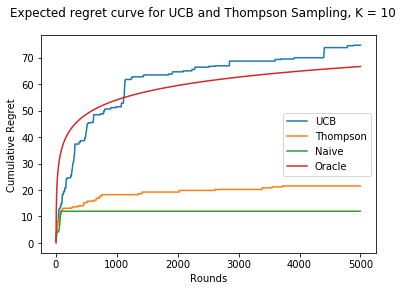

In [127]:
plt.figure(1, figsize = (6,4))
plt.suptitle("Expected regret curve for UCB and Thompson Sampling, K = 10")
x = np.arange(1, T+1)
plt.plot(x, reg1, label='UCB')
plt.plot(x, reg2, label='Thompson')
plt.plot(x, reg0, label='Naive')
plt.plot(x, oracle_trajectory, label='Oracle')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
#plt.savefig('Figures/bernoulli_K{}.png'.format(K))
plt.show()

# Non Parametric Bandit

## Thompson sampling for general stochastic bandits

In [130]:
def TS_general(T, MAB):
    K = len(MAB)

    N = np.zeros((K, T))
    S = np.zeros((K, T))
    
    rew, draws = [], []

    draw_theta_a = lambda a, t, N, S: np.random.beta(S[a,t]+1, 
                                            N[a,t]-S[a,t]+1) if (N[a,t] > 0) else np.random.uniform()    
    draw_theta = lambda t, N, S: np.array([draw_theta_a(a, t, N, S) for a in range (K)])
    
    # TS algorithm for general stochastic bandits
    for t in range (T):
        theta = draw_theta(t, N, S)
        k = np.argmax(theta)
        i = MAB[k].sample()
        s = np.random.rand(1) < i
        N[k, t:] += 1
        S[k, t:] += s

        draws += [k]
        rew += [s]
        
    return rew, draws

In [131]:
K = 20 
n_bernoulli = round(0.3*K)
n_beta = round(0.3*K)
n_exp = round(0.4*K)

MAB_bernoulli = [arms.ArmBernoulli(np.random.random(), random_state=np.random.randint(1, 312414)) 
                 for n in range(n_bernoulli)]
MAB_beta = [arms.ArmBeta(np.random.random(), np.random.random(), random_state=np.random.randint(1, 312414)) 
            for n in range(n_beta)]
MAB_exp = [arms.ArmExp(np.random.random(), random_state=np.random.randint(1, 312414)) 
           for n in range(n_exp)]
MAB_NP = MAB_bernoulli + MAB_beta + MAB_exp

In [132]:
# bandit : set of arms
nb_arms = len(MAB_NP)
means = [el.mean for el in MAB_NP]

# Display the means of your bandit (to find the best)
print('means: {}'.format(means))
mu_max = np.max(means)


T = 5000  # horizon
nb_simu = 10 # Number of simulations

mean_regret_r1 = np.zeros(5000)
mean_regret_2r = np.zeros(5000)
for k in tqdm(range(nb_simu)):
    x = np.arange(1, T+1)
    rew1, draws1 = UCB1(T, MAB_NP)
    expected_r1 = np.array([means[d] for d in draws1])
    reg1 = mu_max * x - np.cumsum(expected_r1)
    rew2, draws2 = TS_general(T, MAB_NP)
    expected_2r = np.array([means[d] for d in draws2])
    reg2 = mu_max * x - np.cumsum(expected_2r)


    mean_regret_r1 = mean_regret_r1 + reg1
    mean_regret_2r = mean_regret_2r + reg2

mean_regret_r1 = mean_regret_r1/nb_simu
mean_regret_2r = mean_regret_2r/nb_simu

  0%|          | 0/10 [00:00<?, ?it/s]

means: [0.33794913776212077, 0.2704449397546933, 0.09061987075939171, 0.8354288759341523, 0.20811572538919332, 0.03943597915631303, 0.45485351882054603, 0.9293751991220701, 0.9647518939100888, 0.5449013410233293, 0.16057080997457293, 0.41801222156439033, 0.4837930621007908, 0.48439235808291486, 0.47850595776168636, 0.4263931392944809, 0.4843393335407312, 0.4323970053255838, 0.4939180454624743, 0.44491928741323106]


100%|██████████| 10/10 [00:07<00:00,  1.33it/s]


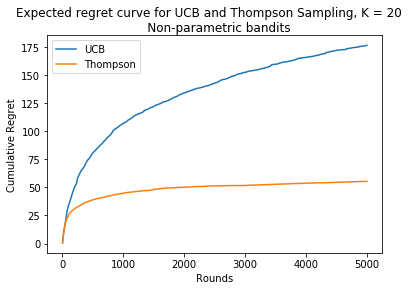

In [135]:
plt.figure(1, figsize = (6,4))
x = np.arange(1, T+1)
plt.plot(x, mean_regret_r1, label='UCB')
plt.plot(x, mean_regret_2r, label='Thompson')
plt.xlabel('Rounds')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.savefig('Figures/NP_bernoulli_K{}.png'.format(K))
plt.suptitle("Expected regret curve for UCB and Thompson Sampling, K = {}\n \
    Non-parametric bandits".format(K))
plt.show()

# Linear Bandit Problem

In [137]:
import numpy as np
from linearmab_models import ToyLinearModel, ColdStartMovieLensModel
import matplotlib.pyplot as plt
from tqdm import tqdm

In [138]:
random_state = np.random.randint(0, 24532523)
model = ColdStartMovieLensModel(
    random_state=random_state,
    noise=0.1)
n_a = model.n_actions

In [139]:
# Linear UCB algorithm
def get_theta(ZZ_ldaI_1, Zy):
    return ZZ_ldaI_1.dot(Zy.T)
    
def get_beta_a(ZZ_ldaI_1, a, lda, alpha, features):
    d = len(features[0])
    out = alpha*(features[a].T.dot(ZZ_ldaI_1).dot(features[a]))**0.5
    return out

def Simulation(model, nb_simu = 1, T = 30, lda = 0.1, 
               alpha = 1, alpha_fun = lambda a,t:a/(t+1), 
               algo = 'UCB', eps = 0.1):
    d = model.n_features
    K = model.n_actions
    theta_tab = []
    regret = np.zeros((nb_simu, T))
    esp_regret = np.zeros((nb_simu, T))
    norm_dist = np.zeros((nb_simu, T))

    for k in tqdm(range(nb_simu), desc="Simulating {}".format(algo)):
        # Linear UCB
        # init
        a = np.random.randint(0, K)
        Z = model.features[a].reshape(1, -1)
        old_Z = model.features[a].reshape(1, -1)
        r = model.reward(a)[0]
        y = [r]
        # We will compute ZZ_LdaI and Zy incrementaly 
        ZZ_LdaI = Z.T.dot(Z) + lda*np.eye(d)
        Zy = Z.T.dot(np.array([r]))
        for t in range (T):
            ZZ_ldaI_1 = np.linalg.inv(ZZ_LdaI)
            theta = get_theta(ZZ_ldaI_1, Zy)
            theta_tab.append(theta)
            if algo == 'UCB':
                alp = alpha_fun(alpha, t)
                beta = np.vectorize(lambda x:get_beta_a(ZZ_ldaI_1, 
                                                        x, 
                                                        lda, 
                                                        alp, 
                                                        model.features))(np.arange(0, K))
                score = model.features.dot(theta) + beta#.reshape(-1,1)
                a_t = np.argmax(score) 
            elif algo == 'random':
                a_t = np.random.randint(0, K)
            elif algo == 'greedy':
                p = np.random.rand() < eps
                if p:
                    a_t = np.random.randint(0, K)
                else:
                    a_t = np.argmax(model.features.dot(theta))
            else:
                raise 'Incorrect algorithm name'
            r_t = model.reward(a_t)[0]
            new_Z = model.features[a_t].reshape(1, -1)
            ZZ_LdaI = np.add(ZZ_LdaI, new_Z.T.dot(new_Z) )
            Zy = Zy + new_Z.T.dot(np.array([r_t]))
            regret[k, t] = model.best_arm_reward() - r_t
            esp_regret[k, t] = model.best_arm_reward() - get_estimated_mean(model, model.real_theta)[a_t]
            norm_dist[k, t] = np.linalg.norm(theta - model.real_theta, 2)
    mean_norms = np.mean(norm_dist, axis = 0)
    mean_regret = np.mean(esp_regret, axis = 0)

    return mean_norms, mean_regret

In [140]:
def get_estimated_mean(model, theta):
    return [model.features[a].dot(theta) for a in range(model.n_actions)]

def random_pick(model, T):
    n_a = model.n_actions
    d = model.n_features
    rew, draws = [], []
    for t in range(T):
        a = np.random.randint(0, n_a)
        draws += [a]
        rew += [model.reward(a)[0]]
    return draws, rew

def eps_greedy(model, T):
    n_a = model.n_actions
    ratings = [model.features]

def average_regret(model, draws, t):
    draws = draws[:t]
    T = len(draws)
    true_means = get_estimated_mean(model, model.real_theta)
    return t * model.best_arm_reward() - np.sum([true_means[d] for d in draws])

## Testing parameters

### UCB

In [54]:
nb_simu = 10 
T = 2000
d = model.n_actions

# Parameter for UCB confidence intervals
alpha_fun = lambda a, t : a*sqrt(log((1 + t)))
alphas = np.logspace(-2, 2, 10)
mean_norms, mean_regret = {}, {}
for alpha in alphas :
    mean_norms[alpha], mean_regret[alpha] = Simulation(model, 
                                               nb_simu=nb_simu, 
                                               T = T, 
                                               lda = .1, 
                                               alpha = alpha, 
                                               alpha_fun=alpha_fun, 
                                               algo = 'UCB', 
                                               eps = 0.1)

Simulating UCB: 100%|██████████| 10/10 [00:22<00:00,  2.27s/it]


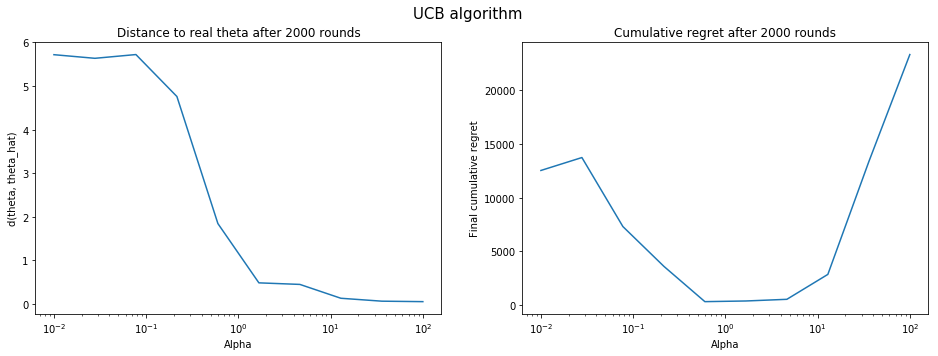

In [60]:
final_norm = [mean_norms[k][-1] for k in mean_norms]
cum_regret = [mean_regret[k].cumsum()[-1] for k in mean_regret]

plt.figure(figsize=(16, 5))
plt.suptitle('UCB algorithm', size = 15)
plt.subplot(121)
plt.plot(alphas, final_norm)
plt.title("Distance to real theta after {} rounds".format(T))
plt.ylabel('d(theta, theta_hat)')
plt.xlabel('Alpha')
plt.xscale('log')

plt.subplot(122)
plt.plot(alphas, cum_regret)
plt.title("Cumulative regret after {} rounds".format(T))
plt.ylabel('Final cumulative regret')
plt.xlabel('Alpha')
plt.xscale('log')
plt.plot()
#plt.savefig("Figures/alpha_{}-{}.png".format(min(alphas), max(alphas)))

### Epsilon

In [98]:
nb_simu = 2 
T = 6000

alpha_fun = lambda a, t: a*sqrt(log((1 + t)))
epsilons = np.linspace(0.3, 1, 5)
mean_norms, mean_regret = {}, {}
for eps in epsilons :
    mean_norms[eps], mean_regret[eps] = Simulation(model, 
                                               nb_simu=nb_simu, 
                                               T = T, 
                                               lda = .1, 
                                               alpha = 5, 
                                               alpha_fun=alpha_fun, 
                                               algo = 'greedy', 
                                               eps = eps)

Simulating greedy: 100%|██████████| 2/2 [00:04<00:00,  2.46s/it]


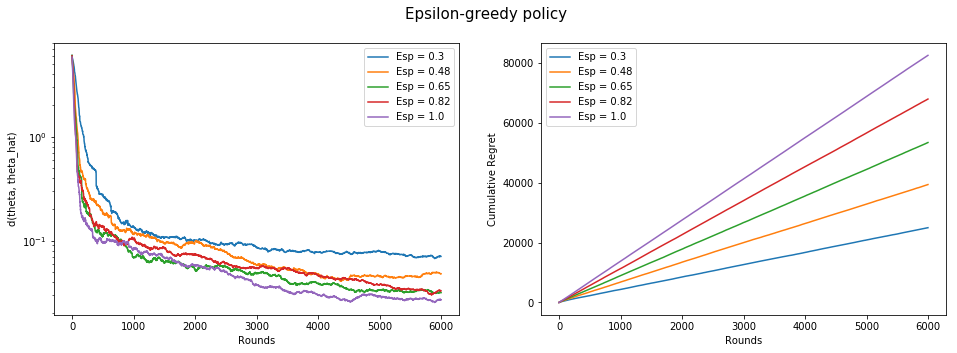

In [94]:
plt.figure(figsize=(16, 5))
plt.suptitle('Epsilon-greedy policy', size = 15)

plt.subplot(121)
for eps in epsilons:
    plt.plot(mean_norms[eps], label='Esp = {}'.format(round(eps,2)))
plt.ylabel('d(theta, theta_hat)')
plt.yscale('log')
plt.xlabel('Rounds')
plt.legend()

plt.subplot(122)
for eps in epsilons:
    plt.plot(mean_regret[eps].cumsum(), label='Esp = {}'.format(round(eps,2)))
plt.ylabel('Cumulative Regret')
plt.xlabel('Rounds')
plt.legend()

plt.savefig("Figures/full_eps_{}-{}.png".format(min(alphas), max(alphas)))
plt.show()

## Comparison of the algorithms

In [103]:
nb_simu = 10 
T = 6000
alpha_fun = lambda a, t: a*sqrt(log((1 + t)))
algos = ['UCB', 'random', 'greedy']
mean_norms, mean_regret = {}, {}
for alg in algos :
    mean_norms[alg], mean_regret[alg] = Simulation(model, 
                                               nb_simu=nb_simu, 
                                               T = T, 
                                               lda = .1, 
                                               alpha = 10, 
                                               alpha_fun=alpha_fun, 
                                               algo = alg, 
                                               eps = 0.3)

Simulating greedy: 100%|██████████| 10/10 [00:22<00:00,  2.31s/it]


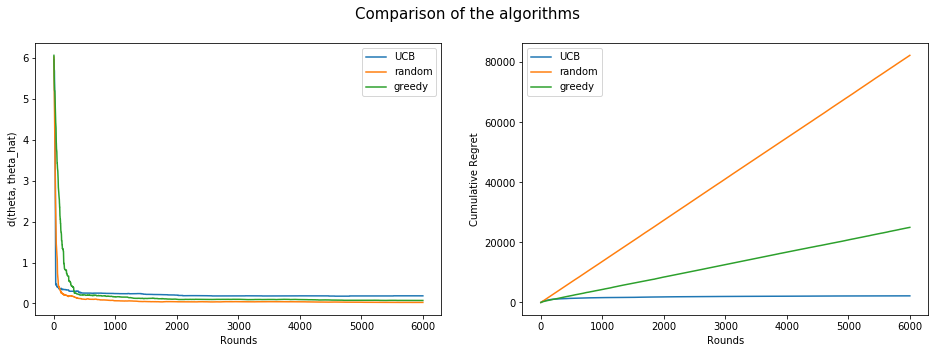

In [105]:
plt.figure(figsize=(16, 5))
plt.suptitle('Comparison of the algorithms', size = 15)

plt.figure(1)
plt.subplot(121)
for alg in algos :
    plt.plot(mean_norms[alg], label=alg)
plt.ylabel('d(theta, theta_hat)')
plt.xlabel('Rounds')
plt.legend()

plt.subplot(122)
for alg in algos :    
    plt.plot(mean_regret[alg].cumsum(), label=alg)
plt.ylabel('Cumulative Regret')
plt.xlabel('Rounds')
plt.legend()

plt.savefig("Figures/algo_comp_{}.png".format(nb_simu))
plt.show()